## Knapsack optimization with Q-learning

State: $s_i = i$, current item $i$ \
Action: $a_t = 0$ (do not select any knapsack), $a_t = k$ (select knapsack $k$) \
Reward: $r_t = v_i$ if $a = k$ and $w_i \leq c_k$ or $r_t = -v_i / 2$

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import torch.nn as nn
import torch
import torch.nn.functional as F

In [6]:
np.random.seed(42)

## Utils

In [7]:
n_knapsacks = 50
n_items = 100
max_capacity = 100
min_capacity = 1
max_value = 10
max_weight = 100

def generate_knapsack_problem():
    knapsack_ids = [f"knapsack{i + 1}" for i in range(n_knapsacks)]
    capacities = np.random.randint(min_capacity, max_capacity, n_knapsacks)
    knapsack_df = pd.DataFrame({"id": knapsack_ids, "capacities": capacities })
    
    item_ids = [f"item{i + 1}" for i in range(n_items)]
    values = np.random.randint(1, max_value + 1, n_items)
    weights = np.random.randint(1, max_weight + 1, n_items)
    item_df = pd.DataFrame({"id": item_ids, "value": values, "weight": weights})
    
    return knapsack_df, item_df

In [8]:
knapsack_df, item_df = generate_knapsack_problem()

In [8]:
knapsack_df.head()

,id,capacities
0,knapsack1,52
1,knapsack2,93
2,knapsack3,15
3,knapsack4,72
4,knapsack5,61


In [9]:
item_df.head()

,id,value,weight
0,item1,4,28
1,item2,9,28
2,item3,2,44
3,item4,10,84
4,item5,9,30


## Q-learning

In [7]:
episodes = 10_000
initial_capacities = knapsack_df["capacities"]
n_actions = len(knapsack_df) + 1 # Action 0 = skip item
n_items = len(item_df)
weights = item_df["weight"]
values = item_df["weight"]
q_table = np.zeros((n_items, n_actions))
learning_rate = 0.1
discount_rate = 0.95
min_exploration_rate = 0.2
max_exploration_rate = 1.0
exploration_rate = max_exploration_rate
exploration_decay_rate = 0.01

cumulative_rewards = []

for episode in range(episodes):
    current_capacities = initial_capacities.copy()
    cumulative_reward = 0

    for item in range(n_items):
        if np.random.uniform() < exploration_rate:
            action = np.random.choice(n_actions)
        else:
            action = np.argmax(q_table[item])

        #print(f"Action {action} capacity {current_capacities[action - 1]}, weight {weights[item]}")
        if action == 0:
            reward = 0
        elif weights[item] <= current_capacities[action - 1]:
            # Place in the knapsack
            reward = item_df["value"][item]
            #print(f"Item {item} - Action {action} - Current capacity {current_capacities[action - 1]} and value {item_df["value"][item]}")
            current_capacities[action - 1] -= item_df["weight"][item]
        elif weights[item] > current_capacities[action - 1]:
            #print(f"Item {item} - Action {action} - Current capacity {current_capacities[action - 1]} and value {-item_df["value"][item] * 0.5}")
            # Penalize if trying to add without enough capacity
            reward = -item_df["value"][item] * 0.5

        # Update Q-table for Q(s,a)
        q_table[item, action] = q_table[item, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[item + 1, :]))

        cumulative_reward += reward
        
        if item + 1 == n_items - 1:
            break

    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)

    cumulative_rewards.append(cumulative_reward)
    #print(f"Episode: {episode}, Cumulative Reward: {cumulative_reward}")

/tmp/ipykernel_8240/501649906.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


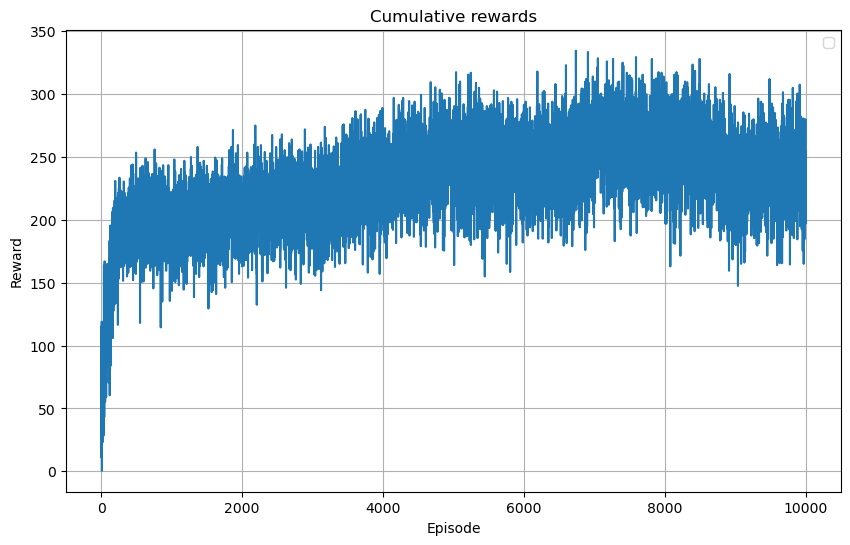

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_rewards)
#plt.plot(steps, exploration_rates, label='Exploration Rate', color='blue')
plt.title('Cumulative rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid()
plt.show()

In [9]:
def get_policy():
    policy = []
    current_capacities = initial_capacities.copy()
    for item in range(n_items):
        action = np.argmax(q_table[item])  # Always select the best action from Q-table for each item
        if action > 0 and weights[item] <= current_capacities[action - 1]:
            policy.append(action)  # Add the action to the policy if it is feasible
            current_capacities[action - 1] -= weights[item]  # Update capacity if the item is placed
        else:
            policy.append(0)  # Append 0 (do nothing) if the action is not feasible
    return policy

In [10]:
def get_total_value():
    policy = get_policy()
    return sum(values[i] for i, a in enumerate(policy) if a > 0)

In [11]:
get_total_value()

2126

## Deep Q-Network (DQN)

In [17]:
class KnapsackEnv(gym.Env):
    def __init__(self, items, capacities):
        super().__init__()
        self.items = np.array(items)
        self.capacities = np.array(capacities)

        self.num_items = len(items)
        self.num_bags = len(capacities)

        # Each individual item has a choice to put itself into one of the bag
        self.action_space = spaces.Discrete(self.num_items * self.num_bags)

        self.observation_space = spaces.Dict({
            'item_values': spaces.Box(low=0, high=np.inf, shape=(self.num_items,), dtype=np.float32),
            'item_weights': spaces.Box(low=0, high=np.inf, shape=(self.num_items,), dtype=np.float32),
            'remaining_capacities': spaces.Box(low=0, high=np.max(capacities), shape=(self.num_bags,), dtype=np.float32),
            # Binary choice for each item: whether the item can be selected for the knapsack or not
            'selection_status': spaces.MultiBinary(self.num_items)
        })

        self.time_step = -1
        
        self.state = None
        self.reset()

    def reset(self):
        self.state = {
            'item_values': self.items[:, 0],
            'item_weights': self.items[:, 1],
            'remaining_capacities': self.capacities.copy(),
            'selection_status': np.zeros(self.num_items, dtype=int)
        }
        self.time_step = -1

        return self._prepare_state()

    def _prepare_state(self):
        item_values = np.array(self.state['item_values'], dtype=np.float32)
        item_weights = np.array(self.state['item_weights'], dtype=np.float32)
        remaining_capacities = np.array(self.state['remaining_capacities'], dtype=np.float32)
        selection_status = np.array(self.state['selection_status'], dtype=np.float32)
        
        ret = np.concatenate([item_values, item_weights, remaining_capacities, selection_status])
        ret = ret.reshape(1, len(ret))
        return ret

    def step(self, action):
        item_idx = action % self.num_items
        bag_idx = action // self.num_items
        
        item_value = self.items[item_idx, 0]
        item_weight = self.items[item_idx, 1]

        if self.state['selection_status'][item_idx] == 0 and self.state['remaining_capacities'][bag_idx] >= item_weight:
            self.state['remaining_capacities'][bag_idx] -= item_weight
            self.state['selection_status'][item_idx] = 1
            reward = item_value
        else:
            reward = 0

        no_more_fits = np.all(self.state['remaining_capacities'] < np.min(self.items[self.state['selection_status'] == 0, 1]))
        done = np.all(self.state['selection_status']) or no_more_fits

        mask = self._valid_actions()

        # next_obs, reward, terminated, mask
        return self._prepare_state(), reward, done, mask

    def _valid_actions(self):
        mask = np.zeros(self.num_items * self.num_bags, dtype=bool)
        for i in range(self.num_items):
            for j in range(self.num_bags):
                if self.state["selection_status"][i] == 0 and self.state['remaining_capacities'][j] >= self.items[i][1]:
                    mask[i + j * self.num_items] = True
        return mask.reshape(1, len(mask))

    # def _valid_actions(self):
    #     # Create a mask initialized to False
    #     mask = np.zeros(self.num_items * self.num_bags, dtype=bool)
    
    #     # Extract selection status and remaining capacities
    #     selection_status = self.state["selection_status"]
    #     remaining_capacities = self.state["remaining_capacities"]
    
    #     # Create a boolean array for items that are not selected
    #     not_selected = selection_status == 0
    
    #     # Create a 2D array of item weights, where each row corresponds to an item
    #     item_weights = np.array([item[1] for item in self.items])
    
    #     # Create a 2D array of remaining capacities, where each column corresponds to a bag
    #     capacities = remaining_capacities[:, np.newaxis]  # Shape: (num_bags, 1)
    
    #     # Check which items can be added to which bags
    #     valid_actions = not_selected[:, np.newaxis] & (capacities >= item_weights)
    
    #     # Flatten the valid_actions array and convert to a boolean mask
    #     mask = valid_actions.flatten()
    
    #     return mask.reshape(1, len(mask))

In [13]:
class ReplayBuffer:
    def __init__(self, obs_dim: int, max_size: int, batch_size: int) -> None:
        self.max_size = max_size
        self.batch_size = batch_size
        self.size = 0
        self.idx = 0

        # TODO: These could be compressed into a single experience
        self.obs_buf = np.zeros((max_size, obs_dim), dtype=np.float32)
        self.action_buf = np.zeros((max_size,), dtype=np.int64)
        self.next_obs_buf = np.zeros((max_size, obs_dim), dtype=np.float32)
        self.reward_buf = np.zeros((max_size,), dtype=np.float32)
        self.terminated_buf = np.zeros((max_size,), dtype=np.float32)
        
    def store(self, obs: np.ndarray, action: np.ndarray, next_obs: np.ndarray, reward: np.ndarray, terminated: np.ndarray):
        batch_size = obs.shape[0]
        idxs = np.arange(self.idx, self.idx + batch_size) % self.max_size
        
        self.obs_buf[idxs] = obs
        self.action_buf[idxs] = action
        self.next_obs_buf[idxs] = next_obs
        self.reward_buf[idxs] = reward
        self.terminated_buf[idxs] = terminated
        
        self.idx = (self.idx + batch_size) % self.max_size
        self.size = min(self.size + batch_size, self.max_size)
        
    def sample(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        idxs = np.random.choice(self.size, self.batch_size, replace=False)
        
        obs = self.obs_buf[idxs]
        action = self.action_buf[idxs]
        next_obs = self.next_obs_buf[idxs]
        reward = self.reward_buf[idxs]
        terminated = self.terminated_buf[idxs]
        
        return obs, action, next_obs, reward, terminated

In [14]:
class QNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden_dim=256) -> None:
        super(QNetwork, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )
    
    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.model(obs)

In [24]:
class DQN():
    def __init__(self, obs_dim, n_actions, n_nonselectability_flags, device="cuda", epoch=3, lr=1e-3, gamma=0.99, max_size=1000, batch_size=32, eps=1.0, eps_decay=0.995, min_eps=0.01, target_net_update_freq=100) -> None:
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.n_nonselectability_flags = n_nonselectability_flags
        self.device = torch.device(device)
        self.epoch = epoch
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps = eps
        self.eps_decay = eps_decay
        self.min_eps = min_eps
        self.target_net_update_freq = target_net_update_freq
        self.time_step = -1
        
        self.q_network = QNetwork(obs_dim, n_actions).to(self.device)
        self.target_network = QNetwork(obs_dim, n_actions).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        
        self.replay_buffer = ReplayBuffer(obs_dim, max_size, batch_size)

    # TODO: This should be in Agent class
    # TODO: Agent class should take EpsilonGreedyStrategy
    @torch.no_grad()
    def select_action(self, obs, mask):
        """
        Select an action based on the current observation.

        Args:
            obs (ndarray): `(n_envs, obs_dim)`

        Returns:
            action (ndarray): `(n_envs,)`
        """
        if np.random.rand() < self.eps:
            # Explore
            # Logits = raw prediction scores
            rand_logits = np.random.rand(obs.shape[0], self.n_actions)
            rand_logits[~torch.BoolTensor(mask)] = -float('inf')
            return np.argmax(rand_logits, axis=-1)
        
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float32).to(self.device)
        else:
            # Detach = do not calculate gradients
            obs = obs.clone().detach().to(self.device)

        q_values = self.q_network(obs)
        q_values[~torch.BoolTensor(mask)] = -float('inf')
        return torch.argmax(q_values, dim=-1).cpu().numpy()

    # TODO: use named tuple
    def update(self, obs: np.ndarray, action: np.ndarray, next_obs: np.ndarray, reward: np.ndarray, terminated: np.ndarray):
        """
        Update DQN.

        Args:
            obs (ndarray): `(n_envs, obs_dim)`
            action (ndarray): `(n_envs,)`
            next_obs (ndarray): `(n_envs, obs_dim)`
            reward (ndarray): `(n_envs,)`
            terminated (ndarray): `(n_envs,)`
        """
        self.time_step += 1
        self.replay_buffer.store(obs, action, next_obs, reward, terminated)
        
        if self.replay_buffer.size < self.replay_buffer.batch_size:
            return

        td_losses = self._train()
        return {
            "td_losses": td_losses,
            "eps": self.eps,
        }

    def _train(self):
        td_losses = []
        for _ in range(self.epoch):
            # sample from replay buffer
            obs, action, next_obs, reward, terminated = self.replay_buffer.sample()
            obs = torch.tensor(obs, dtype=torch.float32).to(self.device)
            action = torch.tensor(action, dtype=torch.int64).to(self.device)
            next_obs = torch.tensor(next_obs, dtype=torch.float32).to(self.device)
            reward = torch.tensor(reward, dtype=torch.float32).to(self.device)
            terminated = torch.tensor(terminated, dtype=torch.float32).to(self.device)
            
            # feedforward
            q_values = self.q_network(obs) # Q(s, :)
            with torch.no_grad():
                next_q_values = self.target_network(next_obs) # Q(s', :) 
                
            # compute td loss
            q_values = q_values.gather(dim=1, index=action.unsqueeze(-1)).squeeze(-1) # Q(s, a)
            # 1 - terminated = non-final state
            q_target_values = reward + (1 - terminated) * self.gamma * torch.max(next_q_values, dim=-1).values
            td_loss = F.mse_loss(q_values, q_target_values)
            
            # training step
            self.optimizer.zero_grad()
            # Computation graph was created during forward passes of the networks
            # Traverse it backwards to get gradients. Then update model params with the gradients
            td_loss.backward()
            self.optimizer.step()

            td_losses.append(td_loss.item())
        
        self._update_target_net()
        self.eps = max(self.eps * self.eps_decay, self.min_eps)
        
        return td_losses

    def _update_target_net(self):
        if self.time_step % self.target_net_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sample model
model = nn.Linear(10, 1)  # A simple linear model
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()  # Mean Squared Error loss

# Sample data
inputs = torch.randn(5, 10)  # 5 samples, 10 features
targets = torch.randn(5, 1)   # 5 target values

# Training step
optimizer.zero_grad()  # Clear previous gradients
outputs = model(inputs)  # Forward pass
loss = criterion(outputs, targets)  # Compute loss
loss.backward()  # Backward pass to compute gradients
optimizer.step()  # Update model parameters

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sample model
model = nn.Linear(10, 1)  # A simple linear model
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()  # Mean Squared Error loss

# Sample data
inputs = torch.randn(5, 10)  # 5 samples, 10 features
targets = torch.randn(5, 1)   # 5 target values

# Training step
optimizer.zero_grad()  # Clear previous gradients
outputs = model(inputs)  # Forward pass
loss = criterion(outputs, targets)  # Compute loss
loss.backward()  # Backward pass to compute gradients

# Accessing gradients
for name, param in model.named_parameters():
    if param.grad is not None:  # Check if gradients exist
        print(f"Gradient for {name}: {param.grad}")
    else:
        print(f"No gradient for {name}")
        
# Update model parameters
optimizer.step()  # Update model parameters

Gradient for weight: tensor([[-2.8361,  1.9633,  0.2093, -2.3550,  0.0468, -0.6781, -1.3094,  1.8112,
          2.1006,  0.0558]])
Gradient for bias: tensor([-2.7828])


In [21]:
# Create a 2D tensor (e.g., Q-values for 3 states and 2 actions)
q_values = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
print("Q-values:\n", q_values)

# Create an index tensor for actions taken
actions = torch.tensor([0, 1, 1])  # Indices of actions taken for each state

# Gather the Q-values for the actions taken
gathered_values = q_values.gather(dim=1, index=actions.unsqueeze(-1))
print("Gathered values:\n", gathered_values)

# actions.unsqueeze(-1)
#q_values.gather(dim=1, index=actions

Q-values:
 tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])
Gathered values:
 tensor([[1.],
        [4.],
        [6.]])


In [19]:
n_items = len(item_df)
n_bags = len(knapsack_df)
weights = item_df['weight'].values
values = item_df['value'].values
capacities = knapsack_df['capacities'].values

episodes = 500

items = [(values[i], weights[i]) for i in range(n_items)]

In [26]:
env = KnapsackEnv(items, capacities)

n_actions = n_bags * n_items
# self.observation_space = spaces.Dict({
#     'item_values':       ...shape=(self.num_items,)...
#     'item_weights':      ...shape=(self.num_items,)...,
#     'selection_status':  ...spaces.MultiBinary(self.num_items)...
#     'remaining_capacities': ...shape=(self.num_bags,)...

# })
obs_dim = 3 * n_items + n_bags
dqn = DQN(obs_dim, n_actions, n_items)

td_loss_list = []
cumulative_reward_list = []
epsilons = []

for e in range(episodes):
    obs = env.reset()
    terminated = False
    cumulative_reward = 0.0
    mask = np.zeros((1, len(values) * len(capacities)), dtype=bool)
    while not terminated:
        # Select action
        action = dqn.select_action(obs, mask)
        next_obs, reward, terminated, _mask = env.step(action)

        # Update the network
        dqn_info = dqn.update(obs, action, next_obs, reward, terminated)
        if dqn_info is not None:
            td_loss_list.append(np.mean(dqn_info["td_losses"]))
            epsilons.append(dqn_info["eps"])
        
        # Move to next state
        obs = next_obs
        mask = _mask
        cumulative_reward += reward

    cumulative_reward_list.append(cumulative_reward)
    if cumulative_reward_list[e].shape == (1,):
        cumulative_reward_list[e] = cumulative_reward_list[e][0]
    else:
        print("Does this really happen?")

    if e % 100 == 0:
        print(f'episode: {e}, cumulative_reward : {cumulative_reward[0]}')

episode: 0, cumulative_reward : 346.0
episode: 100, cumulative_reward : 340.0
episode: 200, cumulative_reward : 346.0
episode: 300, cumulative_reward : 329.0
episode: 400, cumulative_reward : 345.0


In [27]:
ckpt_dict = {
    "agent": dqn.q_network.state_dict(),
    "episodes": episodes,
}
torch.save(ckpt_dict, f"checkpoint.pt")

In [33]:
capacities = knapsack_df['capacities'].values
values = item_df['value'].values
weights = item_df['weight'].values

items = []
for i in range(len(values)):
    items.append((values[i], weights[i]))
            
env = KnapsackEnv(items, capacities)
dqn = DQN(2 * len(values) + len(capacities) + len(values), len(values) * len(capacities), len(values), eps=0.0, min_eps=0.0)
ckpt_dict = torch.load(f"checkpoint.pt")
dqn.q_network.load_state_dict(ckpt_dict["agent"])

/tmp/ipykernel_8240/340052624.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_dict = torch.load(f"checkpoint.pt")


<All keys matched successfully>

In [30]:
def inference(env, dqn):
    obs = env.reset()
    terminated = False
    total_value = 0.0
    mask = np.zeros((1, len(values) * len(capacities)), dtype=bool)
            
    while not terminated:
        action = dqn.select_action(obs, mask)
        obs, reward, terminated, mask = env.step(action)
        total_value += reward
        print(total_value)

    return total_value

In [31]:
inference(env, dqn)

[4.]
[7.]
[15.]
[22.]
[27.]
[29.]
[36.]
[44.]
[50.]
[58.]
[60.]
[70.]
[73.]
[76.]
[77.]
[87.]
[96.]
[101.]
[102.]
[105.]
[111.]
[120.]
[124.]
[133.]
[143.]
[152.]
[160.]
[162.]
[168.]
[173.]
[182.]
[183.]
[189.]
[192.]
[198.]
[200.]
[208.]
[218.]
[225.]
[233.]
[237.]
[244.]
[246.]
[251.]
[260.]
[265.]
[272.]
[280.]
[287.]
[296.]
[303.]
[310.]
[317.]
[318.]
[328.]
[332.]


array([332.])

## Deep Q-Network with transformers (DTQN)

* Observation embedding
* Transformer decoder
* Q-value head

In [31]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

In [43]:
torch.cuda.empty_cache()

In [33]:
n_items = len(item_df)
n_bags = len(knapsack_df)
weights = item_df['weight'].values
values = item_df['value'].values
capacities = knapsack_df['capacities'].values

episodes = 500

items = [(values[i], weights[i]) for i in range(n_items)]

In [34]:
class ReplayBuffer:
    def __init__(self, obs_shape: tuple[int, ...], max_size: int, batch_size: int):
        self.obs_shape = obs_shape
        self.max_size = max_size
        self.batch_size = batch_size
        
        self.obs_buf = torch.zeros((max_size, *obs_shape), dtype=torch.float32)
        self.action_buf = torch.zeros(max_size, dtype=torch.long)
        self.next_obs_buf = torch.zeros((max_size, *obs_shape), dtype=torch.float32)
        self.reward_buf = torch.zeros(max_size, dtype=torch.float32)
        self.terminated_buf = torch.zeros(max_size, dtype=torch.float32)
        
        self.idx = 0
        self.size = 0

    def store(self, obs: torch.Tensor, action: torch.Tensor, next_obs: torch.Tensor, reward: torch.Tensor, terminated: torch.Tensor):
        """
        Store a experience batch in the replay buffer.

        Args:
            obs (Tensor): `(batch_size, *obs_shape)`
            action (Tensor): `(batch_size,)`
            next_obs (Tensor): `(batch_size, *obs_shape)`
            reward (Tensor): `(batch_size,)`
            terminated (Tensor): `(batch_size,)`
        """
        batch_size = obs.shape[0]
        idxs = torch.arange(self.idx, self.idx + batch_size) % self.max_size
        
        self.obs_buf[idxs] = obs.to(dtype=torch.float32)
        self.action_buf[idxs] = action.to(dtype=torch.long)
        self.next_obs_buf[idxs] = next_obs.to(dtype=torch.float32)
        self.reward_buf[idxs] = reward.to(dtype=torch.float32)
        self.terminated_buf[idxs] = terminated.to(dtype=torch.float32)
        
        self.idx = (self.idx + batch_size) % self.max_size
        self.size = min(self.size + batch_size, self.max_size)

    def sample(self, device: torch.device) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Sample a batch from the replay buffer.
        """
        idxs = torch.randint(0, self.size, (self.batch_size,))
        
        obs = self.obs_buf[idxs]
        action = self.action_buf[idxs]
        next_obs = self.next_obs_buf[idxs]
        reward = self.reward_buf[idxs]
        terminated = self.terminated_buf[idxs]
        
        return obs.to(device), action.to(device), next_obs.to(device), reward.to(device), terminated.to(device)

In [35]:
class KnapsackQNetwork(nn.Module):
    def __init__(
        self,
        item_dim: int,
        num_layers: int,
    ):
        super().__init__()
        
        self.obs_embedding_layer = nn.Sequential(
            nn.Linear(item_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )
        
        self.transformer_layer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128,
                nhead=2,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        
        self.q_value_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network. 

        Args:
            obs (Tensor): `(batch_size, n_knapsacks x n_items, item_dim)`
            
        Returns:
            q_value (Tensor): `(batch_size, n_knapsacks x n_items)`
        """
        obs_embedding = self.obs_embedding_layer(obs)
        transformer_output = self.transformer_layer(obs_embedding)
        q_value = self.q_value_layer(transformer_output)
        return q_value.squeeze(-1) # remove the last dimension
    

In [36]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class KnapsackEnv(gym.Env):
    def __init__(self, items = None, capacities = None):
        super(KnapsackEnv, self).__init__()
        
        self.item_dim = 5
        
        if items is not None and capacities is not None:
            self.items = np.array(items)
            self.capacities = np.array(capacities).astype(np.float32)
            self.num_items = len(items)
            self.num_bags = len(capacities)
        else:
            self.items = None 
            self.capacities = None 
            self.num_items = 0
            self.num_bags = 0 
                    
        self.time_step = 0
        self.reset(items, capacities)

    def reset(self, items=None, capacities=None):
        # generate problem that has different(random) item num and bag num... 
        # num_items : between 2 and 100
        # num_bags : ?? 10-30
        # profit, weights [10^-6, 1], normalization will be done just before return     
        
        self.values = self.items[:, 0]
        self.weights = self.items[:, 1]
        
        self.ratios = self.values / self.weights
        self.remaining_capacities = np.array(self.capacities) 
        
        self.max_item_value = np.max(self.values)
        self.max_item_weight = np.max(self.weights)      
        
        self.action_space = np.array(self.num_items * self.num_bags)
        
        # Initialize the state with the items and initial capacity
        self.selectable = np.ones((self.num_items, self.num_bags)).astype(bool)

        # Update each item's profit, weight, ratios, selectable, remaining capacities     
        state = self._make_state()
        norm_state = self._normalize_state(state) 
        self.time_step = 0
        
        return norm_state[np.newaxis, :, :] #add batch dimension

    def step(self, action):
        item_idx = action // self.num_bags
        bag_idx = action % self.num_bags
        
        done = False
        reward = 0
        norm_reward = 0

        if self.selectable[item_idx, bag_idx] == True and self.weights[item_idx] <= self.remaining_capacities[bag_idx]:
            self.selectable[item_idx, :] = False
            self.remaining_capacities[bag_idx] -= self.weights[item_idx]
            reward += self.values[item_idx]
            norm_reward = np.float32(reward) / np.float32(self.max_item_value) #normalization

        # set selectable
        self._update_selctable_matrix()
        
        self.time_step += 1
        # Check if the problem is done (either by running out of capacity or if all items are considered)
        if np.all(~self.selectable):
            done = True

        # set the 'state'
        next_state = self._make_state()  # Add batch dimension
        norm_next_state = self._normalize_state(next_state)
        
        return norm_next_state[np.newaxis, ...], norm_reward, done, {"value": reward} 
    
    def _make_state(self):
        state = np.empty((self.num_items * self.num_bags, self.item_dim), dtype=np.float32)
        state[:, 0] = np.repeat(self.values, self.num_bags)
        state[:, 1] = np.repeat(self.weights, self.num_bags)
        state[:, 2] = np.repeat(self.ratios, self.num_bags)
        state[:, 3] = self.selectable.astype(np.float32).flatten()
        state[:, 4] = np.tile(self.remaining_capacities, self.num_items)
        return state
    
    def _update_selctable_matrix(self):
        # selectable: (n_items, n_bags)
        # weights: (n_items,)
        # remaining_capacities: (n_bags,)
        # broadcast weights and remaining_capacities to (n_items, n_bags)
        # then, compare with selectable
        temp = self.weights[..., np.newaxis] <= self.remaining_capacities[np.newaxis, ...]
        self.selectable = np.logical_and(self.selectable, temp)
    
    def _normalize_state(self, state):
        normstate = state.copy()
        normstate[:, 0] /= self.max_item_value #value
        normstate[:, 1] /= self.max_item_weight #weight
        #ratio is same
        #selectable is same
        normstate[:, 4] /= self.max_item_weight #remaining_capacities
        return normstate
        

In [45]:
class KnapsackDQNTransformerAgent:
    """
    In this problem, the observation of a state is represented by the matrix obtained stacking all the item vectors together. 
    The observation shape is `(n_knapsacks x n_items, item_dim)`.
    Both `n_knapsacks` and `n_items` are not constant and can vary because they're represented as a sequence. 
    Transformer is permutation-invariant, so their order doesn't matter. 
    The item vector can be represented as [value, weight, value/weight, selectability_flag, remaining_knapsack_capacity].
    
    Reference: https://research.tudelft.nl/en/publications/reinforcement-learning-for-the-knapsack-problem
    """
    def __init__(
        self, 
        item_dim: int,
        selectability_flag_idx: int,
        epoch: int = 1,
        gamma: float = 1.0,
        eps: float = 1.0,
        eps_decay: float = 0.995,
        min_eps: float = 0.05,
        tau: float = 0.05,
        replay_buffer_max_size: int = 500,
        batch_size: int = 8,
        num_layers: int = 2,
        device: str = "cuda",
        inference: bool = False,
    ):
        self.item_dim = item_dim
        self.selectability_flag_idx = selectability_flag_idx
        self.epoch = epoch
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.min_eps = min_eps
        self.tau = tau
        self.replay_buffer_max_size = replay_buffer_max_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.inference = inference
        
        self.q_network = KnapsackQNetwork(item_dim, num_layers).to(self.device)
        self.target_network = KnapsackQNetwork(item_dim, num_layers).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.RMSprop(self.q_network.parameters(), lr=1e-6)
        
        self.replay_buffer_dict = dict()


    @torch.no_grad()
    def select_action(self, obs: torch.Tensor) -> torch.Tensor:
        """
        Select an action based on the current observation.
        num_envs = batch size
        Args:
            obs (Tensor): `(num_envs, n_knapsacks x n_items, item_dim)`

        Returns:
            action (Tensor): `(num_envs,)`, the index of the selected knapsack and item
        """
        num_envs, n_knapsack_x_items, _ = obs.shape
        nonselectable_mask = obs[:, :, self.selectability_flag_idx] == 0
        
        # epsilon-greedy policy
        if not self.inference and random.random() < self.eps:
            rand_logits = torch.rand((num_envs, n_knapsack_x_items))
            rand_logits[nonselectable_mask] = -float('inf')
            return rand_logits.argmax(dim=-1).cpu()
        
        q_value = self.q_network(obs.to(self.device))
        q_value[nonselectable_mask] = -float('inf')
        return q_value.argmax(dim=-1).cpu()

    def update(self, obs: torch.Tensor, action: torch.Tensor, next_obs: torch.Tensor, reward: torch.Tensor, terminated: torch.Tensor):
        """
        Update the agent with a single step of experience.

        Args:
            obs (Tensor): `(num_envs, n_knapsacks x n_items, item_dim)`
            action (Tensor): `(num_envs,)`
            next_obs (Tensor): `(num_envs, n_knapsacks x n_items, item_dim)`
            reward (Tensor): `(num_envs,)`
            terminated (Tensor): `(num_envs,)`
        """
        if self.inference:
            return
        
        n_knapsack_x_items = obs.shape[1]
        self._replay_buffer(n_knapsack_x_items).store(obs, action, next_obs, reward, terminated)
        
        if self._replay_buffer(n_knapsack_x_items).size >= self.batch_size:
            td_losses = self._train(n_knapsack_x_items)
            return {
                "td_losses": td_losses,
                "eps": self.eps,
            }

    def _train(self, n_knapsack_x_items: int):
        td_losses = []
        
        for _ in range(self.epoch):
            obs, action, next_obs, reward, terminated = self._replay_buffer(n_knapsack_x_items).sample(self.device)
            
            # feedforward
            q_values = self.q_network(obs)
            with torch.no_grad():
                next_greedy_action = self.target_network(next_obs).argmax(dim=-1)
                next_q_values = self.q_network(next_obs)
                
            # compute td loss
            q_value = q_values.gather(1, action.unsqueeze(-1)).squeeze(-1)
            next_q_value = next_q_values.gather(1, next_greedy_action.unsqueeze(-1)).squeeze(-1)
            target_q_value = reward + (1 - terminated) * self.gamma * next_q_value
            td_loss = F.mse_loss(q_value, target_q_value)
            
            # training step
            self.optimizer.zero_grad()
            td_loss.backward()
            self.optimizer.step()
            
            td_losses.append(td_loss.item())
            
        self._update_target_net()
        self.eps = max(self.eps * self.eps_decay, self.min_eps)
        
        return td_losses
            
    def _update_target_net(self):
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    
    def _replay_buffer(self, n_knapsack_x_items: int) -> ReplayBuffer:
        if n_knapsack_x_items not in self.replay_buffer_dict:
            self.replay_buffer_dict[n_knapsack_x_items] = ReplayBuffer((n_knapsack_x_items, self.item_dim), self.replay_buffer_max_size, self.batch_size)
        return self.replay_buffer_dict[n_knapsack_x_items]

In [46]:
def train(env: KnapsackEnv, agent: KnapsackDQNTransformerAgent, episodes: int, summary_freq: int):
    cumulative_reward_list = []
    td_losses = []
    epsilons = []
    summary_freq = 1
    _start_time = time.time()
    
    for e in range(episodes):
        obs = env.reset()
        obs = torch.from_numpy(obs)
        terminated = False
        cumulative_reward = 0.0
        
        while not terminated:
            action = agent.select_action(obs)
            next_obs, reward, terminated, _ = env.step(action.item())
            
            next_obs = torch.from_numpy(next_obs)
            reward = torch.tensor([reward], dtype=torch.float32)
            terminated = torch.tensor([terminated], dtype=torch.float32)
            
            agent_info = agent.update(
                obs=obs,
                action=action,
                next_obs=next_obs,
                reward=reward,
                terminated=terminated
            )
            
            obs = next_obs
            cumulative_reward += reward.item()
            
            if agent_info is not None:
                td_losses += agent_info["td_losses"]
                epsilons.append(agent_info["eps"])
        
        cumulative_reward_list.append(cumulative_reward)
        if e % summary_freq == 0:
            print(f"Training time: {time.time() - _start_time:.2f}, Episode: {e}, Cumulative Reward: {cumulative_reward}")
            
    return cumulative_reward_list, td_losses, epsilons

In [47]:
def inference(env: KnapsackEnv, agent: KnapsackDQNTransformerAgent):
    obs = env.reset()
    terminated = False
    total_value = 0
    
    while not terminated:
        action = agent.select_action(torch.from_numpy(obs))
        obs, reward, terminated, info = env.step(action.item())
        total_value += info["value"]
        
    return total_value

In [48]:
print(torch.cuda.memory_stats())

OrderedDict({'active.all.allocated': 471, 'active.all.current': 325, 'active.all.freed': 146, 'active.all.peak': 325, 'active.large_pool.allocated': 102, 'active.large_pool.current': 42, 'active.large_pool.freed': 60, 'active.large_pool.peak': 43, 'active.small_pool.allocated': 369, 'active.small_pool.current': 283, 'active.small_pool.freed': 86, 'active.small_pool.peak': 283, 'active_bytes.all.allocated': 10114271744, 'active_bytes.all.current': 3438943232, 'active_bytes.all.freed': 6675328512, 'active_bytes.all.peak': 3438943232, 'active_bytes.large_pool.allocated': 10039710720, 'active_bytes.large_pool.current': 3392844800, 'active_bytes.large_pool.freed': 6646865920, 'active_bytes.large_pool.peak': 3397964800, 'active_bytes.small_pool.allocated': 74561024, 'active_bytes.small_pool.current': 46098432, 'active_bytes.small_pool.freed': 28462592, 'active_bytes.small_pool.peak': 46098432, 'allocated_bytes.all.allocated': 10114271744, 'allocated_bytes.all.current': 3438943232, 'allocated

In [49]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

torch.cuda.memory_allocated: 3.202765GB
torch.cuda.memory_reserved: 3.222656GB
torch.cuda.max_memory_reserved: 3.222656GB
